## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
VotingClassifier, StackingClassifier)
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_score,
recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve)

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [3]:
pastdata = pd.read_csv('INNHotelsGroup_pastdata.csv')
newdata = pd.read_csv('INNHotelsGroup_newdata.csv')

In [4]:
pastdata.set_index('booking_id',inplace=True)
pastdata.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
booking_id,,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN


In [5]:
newdata.set_index('booking_id',inplace=True)
newdata.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled
INNHG_128129,43,Online,1,126.9,2,1,2022-07-01,1,2,Not Canceled


In [6]:
print(f'Past data: rows {pastdata.shape[0]}, columns {pastdata.shape[1]}')

Past data: rows 27093, columns 11


In [7]:
print(f'New data: rows {newdata.shape[0]}, columns {newdata.shape[1]}')

New data: rows 3583, columns 10


## Data Exploration

### Visualization

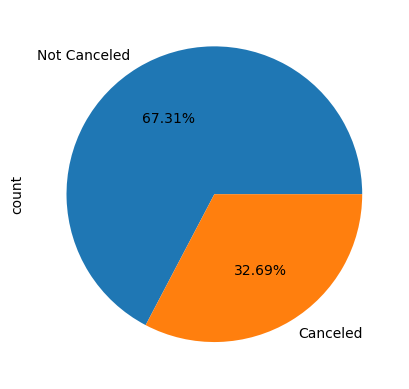

In [8]:
# Let's explore how many canncelled bookings were rebooked

# How many bookings were cancelled
pastdata['booking_status'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

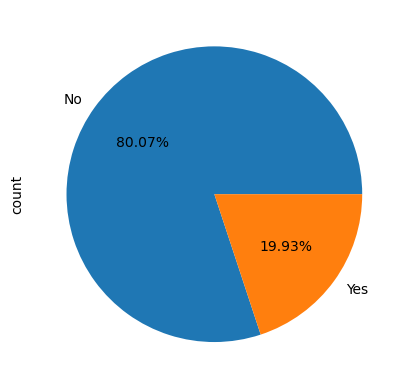

In [9]:
pastdata[pastdata['booking_status']=='Canceled']['rebooked'].value_counts()\
.plot(kind='pie',autopct='%.2f%%')
plt.show()

Inference: Out of total bookings made from 1/1/2021 to 30/6/2022, ~33% bookings were cancelled. Out of these 33% cancelled bookings ~20% were rebooked while ~80% bookings were inventory loss.

In [10]:
# We can drop the column rebooked as its not required in predictive modelling
pastdata.drop(columns=['rebooked'],inplace=True)

In [11]:
# Lets use past data to explore all the columns one by one

### Univariate Analysis

In [12]:
pastdata.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')

In [13]:
num_cols = ['lead_time','avg_price_per_room']
cat_cols = ['market_segment_type', 'no_of_special_requests','no_of_adults', 'no_of_weekend_nights',
           'required_car_parking_space','no_of_week_nights','booking_status']

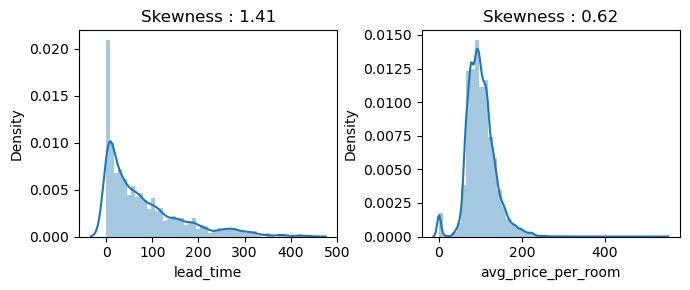

In [14]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.distplot(pastdata[i])
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

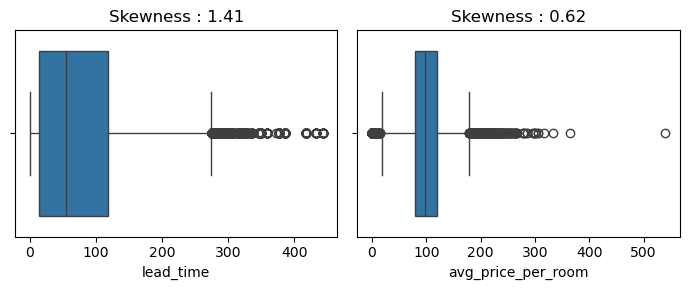

In [15]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i)
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

Inference: There is positive skewness in lead time and avg price per room. In the boxplot we can see that this skewness is beacause of some xtreme outliers present on upper tail of a data.

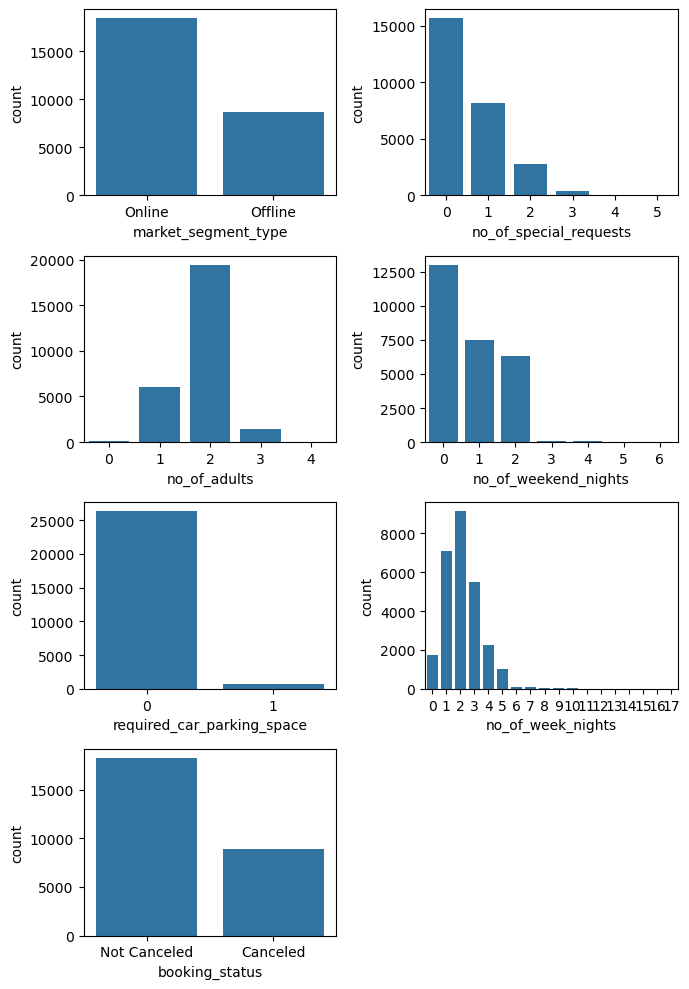

In [16]:
t=1
plt.figure(figsize=(7,10))
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(data=pastdata,x=i)
    t+=1
plt.tight_layout()
plt.show()

Inference: 
* Most of the booking have been done online.
* Most of the guest does not have special requirement of need a car parking space.
* Most of the booking have been made for 2 Adults.
* Most of the booking include 0,1 or 2 weekend nights and 1,2 or 3 weeknights.

### Bivaraite Analysis

<Figure size 700x300 with 0 Axes>

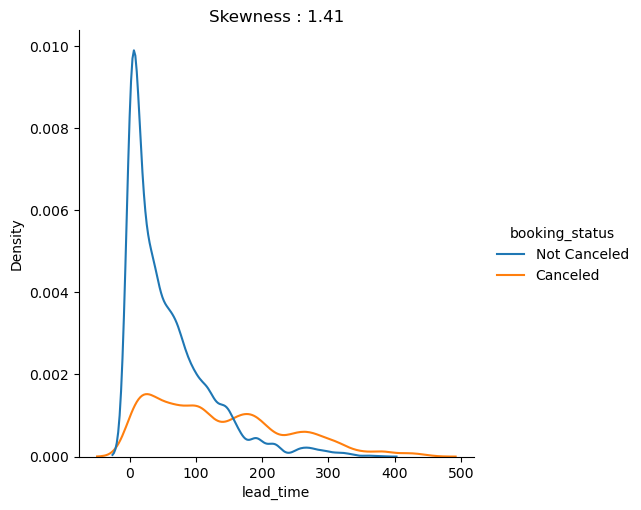

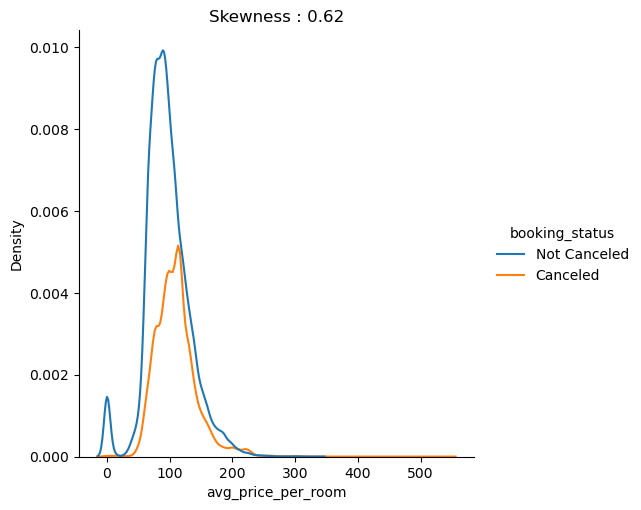

In [17]:
# Num vs cat
plt.figure(figsize=(7,3))
for i in num_cols:
    sns.displot(data = pastdata,x=i,kind='kde',hue='booking_status')
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
plt.show()

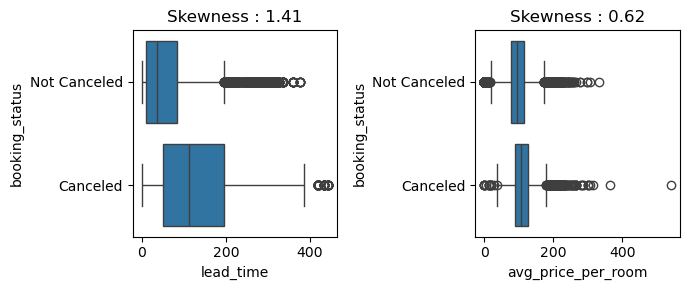

In [18]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i,y='booking_status')
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

Inference:
* Bookings with larger lead times are more prone to get cancelled.
* There are extreme outliers in avg price per rrom where booking is canceled.
* Bookings with Lead time greater than 400 are canceled.
* Bookings with avg room price greater than 350 are canceled.

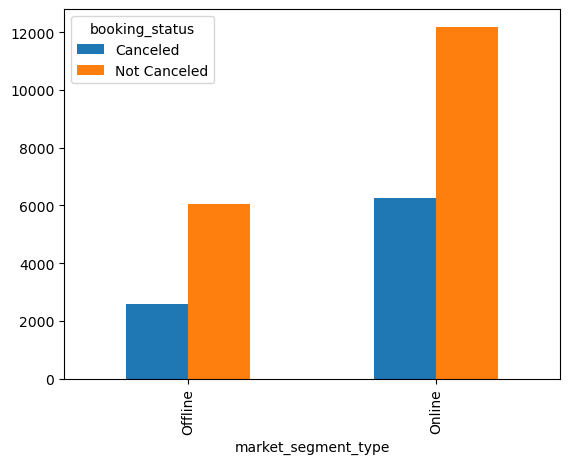

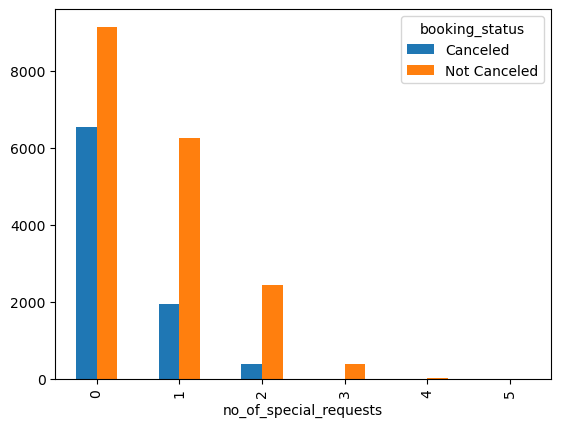

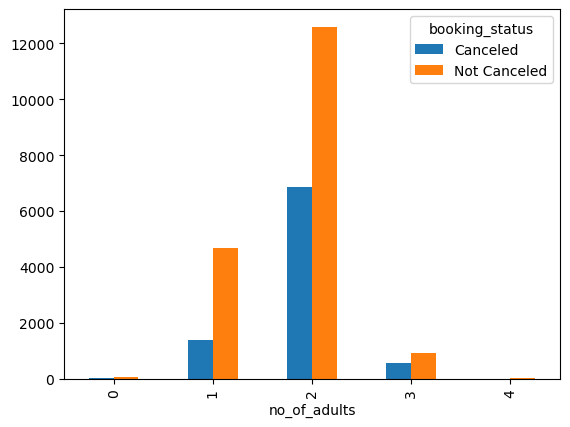

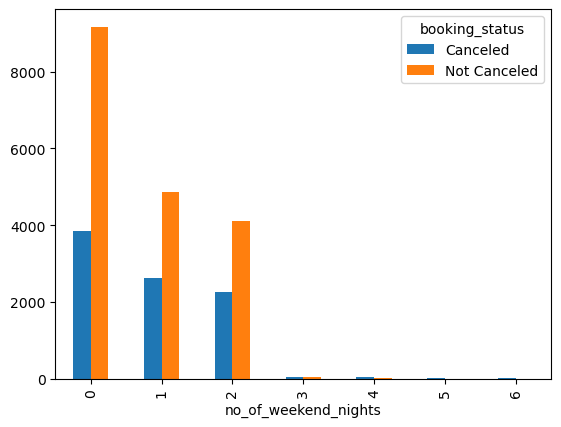

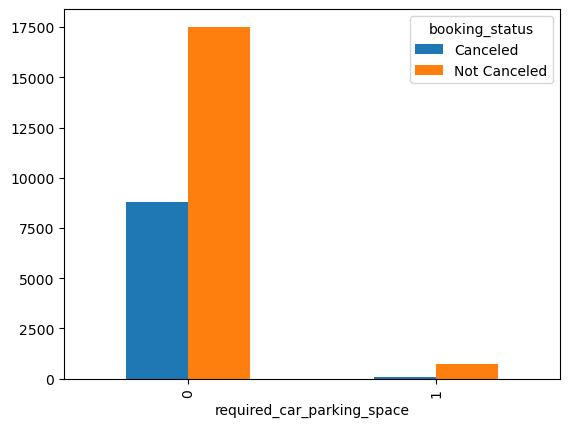

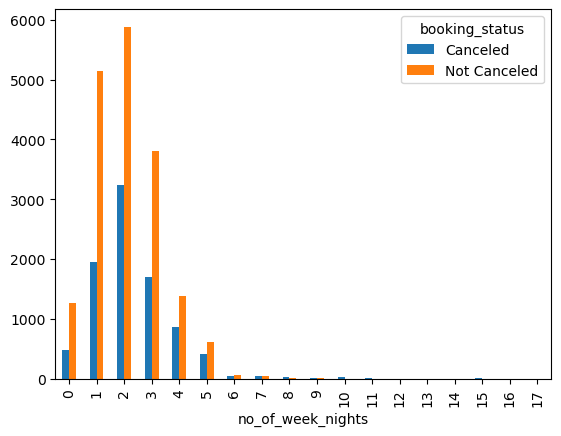

In [19]:
for i in cat_cols:
    if i != 'booking_status':
        pd.crosstab(index=pastdata[i],columns=pastdata['booking_status']).plot(kind='bar')
plt.show()

### Inferential Statistics

In [20]:
# To test Bookings with larger lead times are more prone to get cancelled.
# mu1 = Avg lead time of canceled bookings
# mu2 = Avg lead time of not canceled bookings.

# Ho: mu1 >= mu2
# Ha: mu1 < mu2

samp1 = pastdata[pastdata['booking_status']=='Canceled']['lead_time']
samp2 = pastdata[pastdata['booking_status']=='Not Canceled']['lead_time']

# Check for Assumptions
# Assumption 1 : Normality
print(stats.shapiro(pastdata['lead_time']))
# Assumption 2: Equal Variances
print(stats.levene(samp1,samp2))

# The data fails both the assumptions we need to use non parametric test (Mannwhitneyu's test)

ShapiroResult(statistic=0.8447960019111633, pvalue=0.0)
LeveneResult(statistic=3210.120590252021, pvalue=0.0)


In [21]:

tstat, p_value = stats.mannwhitneyu(samp1,samp2,alternative='less')

# with 95% confidence level, alpha = 0.05
if p_value> 0.05:
    print('Fail to reject Ho:')
else:
    print('Reject Ho:')

Fail to reject Ho:


Inference: Hence we can say that the lead time of canceled bookings is greater that lead time of not canceled bookings.

## Data Preprocessing

### Check for the defects

In [22]:
# Missing values in pastdata and new data
pastdata.isnull().sum().sum()

0

In [23]:
newdata.isnull().sum().sum()

0

In [24]:
# Check for duplicate rows in pastdata
pastdata[pastdata.duplicated()]

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101079,12,Offline,1,85.0,1,1,2021-01-01,0,0,Not Canceled
INNHG_101094,12,Offline,1,85.0,1,1,2021-01-01,0,0,Not Canceled
INNHG_101097,36,Online,0,110.0,1,2,2021-01-01,0,3,Not Canceled
INNHG_101098,231,Online,1,100.3,2,2,2021-01-01,0,2,Canceled
INNHG_101109,61,Online,1,149.4,2,2,2021-01-01,0,3,Not Canceled
...,...,...,...,...,...,...,...,...,...,...
INNHG_128113,113,Offline,0,85.0,2,1,2022-06-30,0,3,Canceled
INNHG_128115,113,Offline,0,85.0,2,1,2022-06-30,0,3,Canceled
INNHG_128118,113,Offline,0,85.0,2,1,2022-06-30,0,3,Canceled


In [25]:
pastdata.drop_duplicates(inplace=True)

In [26]:
pastdata.shape

(18655, 10)

In [27]:
# Capping The extreme outliers from the pastdata

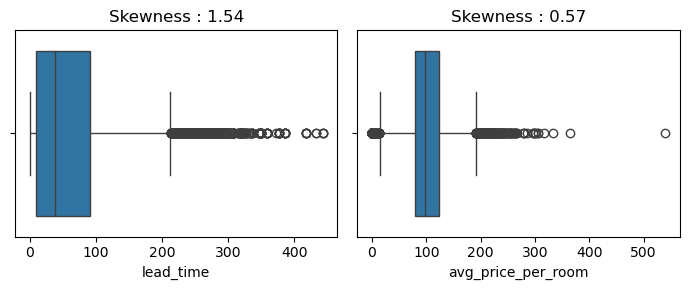

In [28]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i)
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [29]:
for i in num_cols:
    q3,q1 = np.percentile(pastdata[i],[75,25])
    iqr = q3-q1
    ul,ll  = q3+2*iqr, q1-2*iqr
    pastdata[i] = pastdata[i].apply(lambda x: ul if x>ul else ll if x<ll else x)

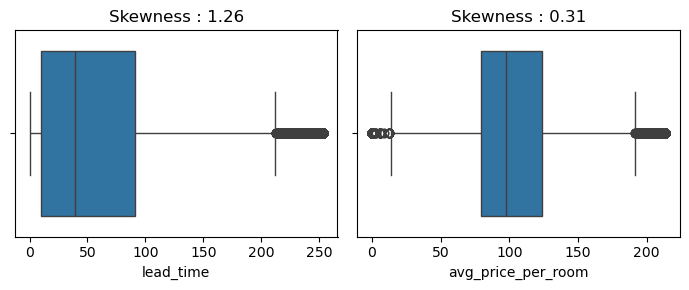

In [30]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i)
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Feature Engineering

In [31]:
pastdata['arrival_date'] = pd.to_datetime(pastdata['arrival_date'])
newdata['arrival_date'] = pd.to_datetime(newdata['arrival_date'])

In [32]:
pastdata['arrival_date'].dt.weekday

booking_id
INNHG_101034    4
INNHG_101035    4
INNHG_101036    4
INNHG_101037    4
INNHG_101038    4
               ..
INNHG_128121    3
INNHG_128123    3
INNHG_128124    3
INNHG_128125    3
INNHG_128126    3
Name: arrival_date, Length: 18655, dtype: int32

In [33]:
# Feature engineering on pastdata
pastdata['arrival_day'] = pastdata['arrival_date'].dt.day
pastdata['arrival_month'] = pastdata['arrival_date'].dt.month
pastdata['arrival_weekday'] = pastdata['arrival_date'].dt.weekday

In [34]:
# Feature engineering on pastdata
newdata['arrival_day'] = newdata['arrival_date'].dt.day
newdata['arrival_month'] = newdata['arrival_date'].dt.month
newdata['arrival_weekday'] = newdata['arrival_date'].dt.weekday

In [35]:
# Lets drop arrival day from both the datasets
pastdata.drop(columns=['arrival_date'],inplace=True)
newdata.drop(columns=['arrival_date'],inplace=True)

In [36]:
pastdata.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,arrival_day,arrival_month,arrival_weekday
booking_id,,,,,,,,,,,,
INNHG_101034,0.0,Online,0,85.03,1,1,0,0,Not Canceled,1,1,4
INNHG_101035,34.0,Online,2,125.10,2,2,0,0,Not Canceled,1,1,4
INNHG_101036,24.0,Online,1,71.69,2,2,0,0,Not Canceled,1,1,4


In [37]:
newdata.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,arrival_day,arrival_month,arrival_weekday
booking_id,,,,,,,,,,,,
INNHG_128127,4,Online,1,103.0,1,0,1,1,Not Canceled,1,7,4
INNHG_128128,147,Online,2,103.7,2,2,0,2,Not Canceled,1,7,4
INNHG_128129,43,Online,1,126.9,2,1,1,2,Not Canceled,1,7,4


### Encoding

In [38]:
pastdata.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,arrival_day,arrival_month,arrival_weekday
booking_id,,,,,,,,,,,,
INNHG_101034,0.0,Online,0,85.03,1,1,0,0,Not Canceled,1,1,4
INNHG_101035,34.0,Online,2,125.10,2,2,0,0,Not Canceled,1,1,4


In [39]:
pastdata['market_segment_type']= pastdata['market_segment_type'].map({'Online':1,'Offline':0})
newdata['market_segment_type']= newdata['market_segment_type'].map({'Online':1,'Offline':0})

In [40]:
pastdata['booking_status'] = pastdata['booking_status'].map({'Canceled':1,'Not Canceled':0})
newdata['booking_status'] = newdata['booking_status'].map({'Canceled':1,'Not Canceled':0})

## Train test Split

In [41]:
y_train = pastdata['booking_status']
x_train = pastdata.drop(columns='booking_status')
y_test = newdata['booking_status']
x_test = newdata.drop(columns='booking_status')

In [42]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(18655, 11) (18655,) (3583, 11) (3583,)


In [43]:
x_train.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_day,arrival_month,arrival_weekday
booking_id,,,,,,,,,,,
INNHG_101034,0.0,1,0,85.03,1,1,0,0,1,1,4
INNHG_101035,34.0,1,2,125.10,2,2,0,0,1,1,4
INNHG_101036,24.0,1,1,71.69,2,2,0,0,1,1,4


In [44]:
x_test.head(3)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_day,arrival_month,arrival_weekday
booking_id,,,,,,,,,,,
INNHG_128127,4,1,1,103.0,1,0,1,1,1,7,4
INNHG_128128,147,1,2,103.7,2,2,0,2,1,7,4
INNHG_128129,43,1,1,126.9,2,1,1,2,1,7,4


## Predictive Modelling

In [45]:
mod = []
accu = []
rec = []
pre = []
f1 = []
ckap = []
def model_validation(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]

    print('Confusion Matrix:\n',confusion_matrix(ytest,pred_h))
    print('\nClassifaction report:\n',classification_report(ytest,pred_h))

    fpr,tpr,thres = roc_curve(ytest,pred_s)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],ls='--',color='red')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,pred_s),2)}')
    plt.show()

    ans = input('Do you want to save the result? Y/N')
    if ans.lower()=='y':
        mod.append(str(model))
        accu.append(accuracy_score(ytest,pred_h))
        pre.append(precision_score(ytest,pred_h))
        rec.append(recall_score(ytest,pred_h))
        f1.append(f1_score(ytest,pred_h))
        ckap.append(cohen_kappa_score(ytest,pred_h))
        global scorecard
        scorecard = pd.DataFrame({'Model':mod,'Accuracy':accu,'Precesion':pre,'Recall':rec,
                                 'F1 Score':f1,'Cohen Kappa':ckap})
    else:
        return

In [46]:
def tuning_parameters(grid,estimator,x,y,score='f1'):
    gscv = GridSearchCV(estimator=estimator,param_grid=grid,verbose=1,scoring=score)
    gscv.fit(x,y)
    return gscv.best_params_

## Class Weight

In [47]:
y_train.value_counts(normalize=True)

booking_status
0    0.711337
1    0.288663
Name: proportion, dtype: float64

In [48]:
weights=y_train.shape[0]/(2*y_train.value_counts()[0]),y_train.shape[0]/(2*y_train.value_counts()[1])


In [49]:
weights

(0.7029012810851545, 1.7321262766945218)

In [50]:
weights_dict={k:v for k,v in zip(range(2),weights)}

In [51]:
weights_dict

{0: 0.7029012810851545, 1: 1.7321262766945218}

Confusion Matrix:
 [[1742  641]
 [ 289  911]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      2383
           1       0.59      0.76      0.66      1200

    accuracy                           0.74      3583
   macro avg       0.72      0.75      0.73      3583
weighted avg       0.77      0.74      0.75      3583



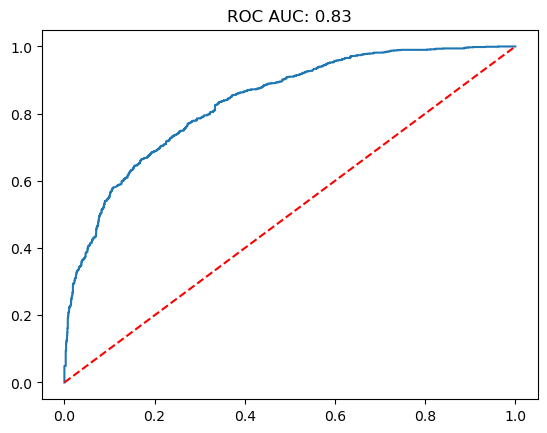

Do you want to save the result? Y/N y


In [52]:
model_validation(LogisticRegression(class_weight=weights_dict),x_train,y_train,x_test,y_test)

In [53]:
scorecard


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.45691


## naive Bayes

Confusion Matrix:
 [[1870  513]
 [ 439  761]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2383
           1       0.60      0.63      0.62      1200

    accuracy                           0.73      3583
   macro avg       0.70      0.71      0.71      3583
weighted avg       0.74      0.73      0.74      3583



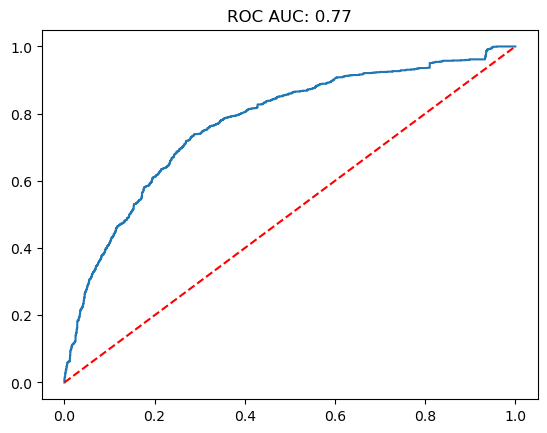

Do you want to save the result? Y/N y


In [54]:
model_validation(GaussianNB(),x_train,y_train,x_test,y_test)

In [55]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577


Confusion Matrix:
 [[2157  226]
 [ 562  638]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85      2383
           1       0.74      0.53      0.62      1200

    accuracy                           0.78      3583
   macro avg       0.77      0.72      0.73      3583
weighted avg       0.77      0.78      0.77      3583



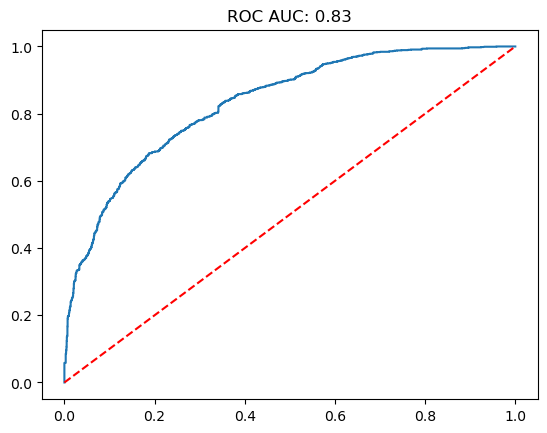

Do you want to save the result? Y/N y


In [56]:
model_validation(LogisticRegression(),x_train,y_train,x_test,y_test)

In [57]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456


Confusion Matrix:
 [[1434  949]
 [ 333  867]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.81      0.60      0.69      2383
           1       0.48      0.72      0.57      1200

    accuracy                           0.64      3583
   macro avg       0.64      0.66      0.63      3583
weighted avg       0.70      0.64      0.65      3583



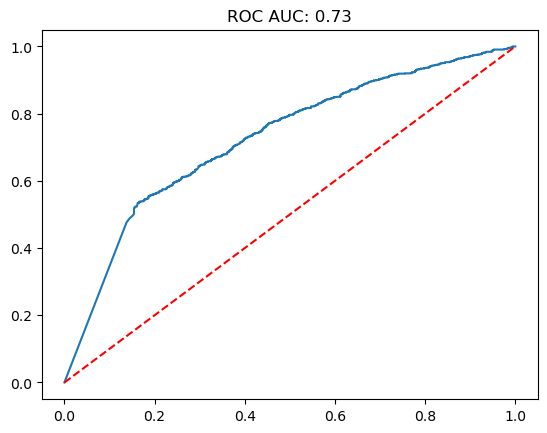

Do you want to save the result? Y/N y


In [58]:
model_validation(MultinomialNB(),x_train,y_train,x_test,y_test)

In [59]:
scorecard


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615


## Decision tree Classifier

In [60]:
best_dt = tuning_parameters(grid={'max_depth':[3,4,5,6,7,8,9,10]},estimator=DecisionTreeClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Confusion Matrix:
 [[1763  620]
 [ 219  981]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81      2383
           1       0.61      0.82      0.70      1200

    accuracy                           0.77      3583
   macro avg       0.75      0.78      0.75      3583
weighted avg       0.80      0.77      0.77      3583



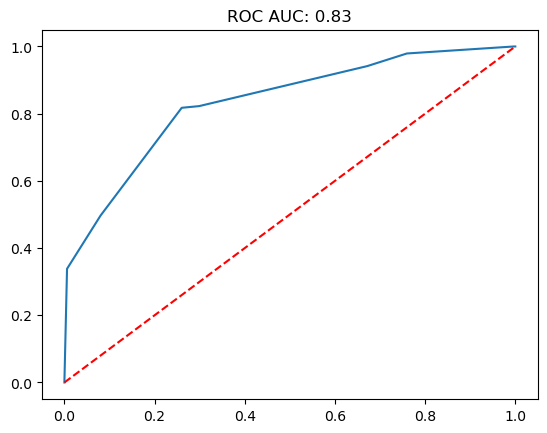

Do you want to save the result? Y/N y


In [61]:
model_validation(DecisionTreeClassifier(**best_dt,class_weight=weights_dict),x_train,y_train,x_test,y_test)

In [62]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637


## random Forest

In [63]:
best_rf = tuning_parameters(
    grid={'max_depth': [3, 9, 10], 'n_estimators': [50, 70, 80]},
    estimator=RandomForestClassifier(max_features=None),
    x=x_train,
    y=y_train
)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Confusion Matrix:
 [[1706  677]
 [ 216  984]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.79      2383
           1       0.59      0.82      0.69      1200

    accuracy                           0.75      3583
   macro avg       0.74      0.77      0.74      3583
weighted avg       0.79      0.75      0.76      3583



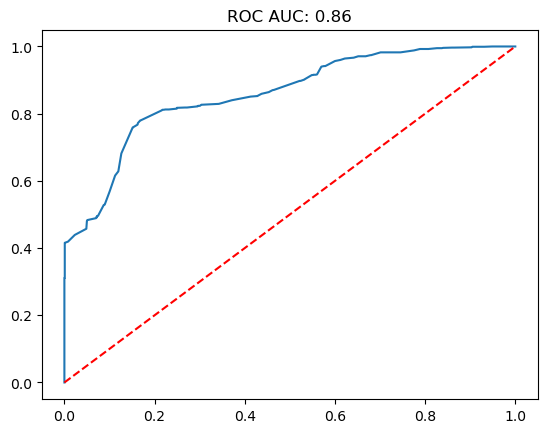

Do you want to save the result? Y/N y


In [64]:
model_validation(RandomForestClassifier(**best_rf,max_features=None,class_weight=weights_dict),x_train,y_train,x_test,y_test)

In [65]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251


In [66]:
y_train.value_counts(normalize=True)

booking_status
0    0.711337
1    0.288663
Name: proportion, dtype: float64

In [67]:
### AdaBoost

best_ada=tuning_parameters(grid={'n_estimators':[50,70,100,120,150]},
                           estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight=weights_dict)),x=x_train,
                          y=y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [68]:
best_ada

{'n_estimators': 120}

Confusion Matrix:
 [[1645  738]
 [ 220  980]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.88      0.69      0.77      2383
           1       0.57      0.82      0.67      1200

    accuracy                           0.73      3583
   macro avg       0.73      0.75      0.72      3583
weighted avg       0.78      0.73      0.74      3583



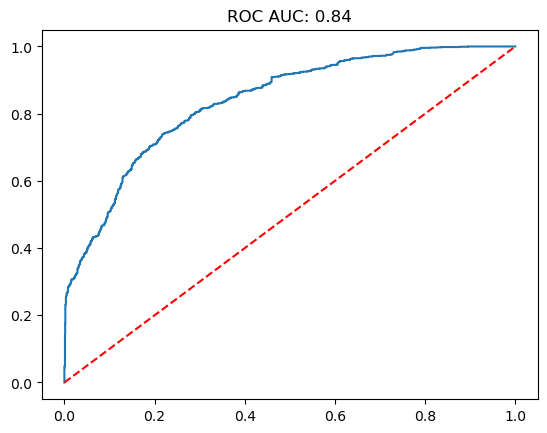

Do you want to save the result? Y/N y


In [69]:
model_validation(AdaBoostClassifier(**best_ada),x_train,y_train,x_test,y_test)

In [70]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251
6,AdaBoostClassifier(n_estimators=120),0.732626,0.570431,0.816667,0.671693,0.457909


## Gradient Boosting

In [71]:
best_gbm=tuning_parameters(grid={'n_estimators':[50,70],'learning_rate':[0.1,0.5],'max_depth':[3,4,5]},
                          estimator=GradientBoostingClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Confusion Matrix:
 [[2143  240]
 [ 319  881]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2383
           1       0.79      0.73      0.76      1200

    accuracy                           0.84      3583
   macro avg       0.83      0.82      0.82      3583
weighted avg       0.84      0.84      0.84      3583



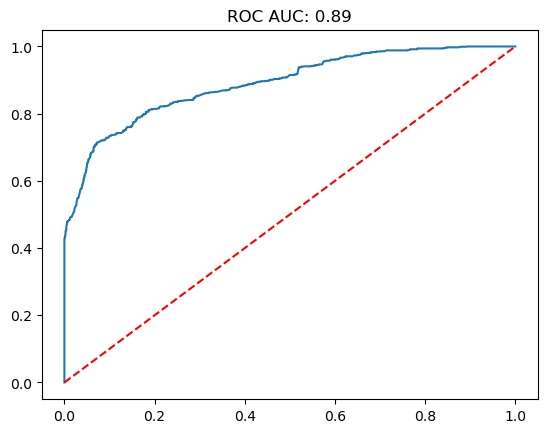

Do you want to save the result? Y/N y


In [72]:
model_validation(GradientBoostingClassifier(**best_gbm),x_train,y_train,x_test,y_test)

In [73]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251
6,AdaBoostClassifier(n_estimators=120),0.732626,0.570431,0.816667,0.671693,0.457909
7,GradientBoostingClassifier(n_estimators=50),0.843985,0.785905,0.734167,0.759156,0.643976


## XGBOOST

In [74]:
from xgboost import XGBClassifier

In [75]:
best_xgb=tuning_parameters(grid={'n_estimators':[70,100,120,150],'learning_rate':[0.1,0.5],'gamma':[1,2,3]},
                           estimator=XGBClassifier(),x=x_train,y=y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


Confusion Matrix:
 [[1889  494]
 [ 266  934]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      2383
           1       0.65      0.78      0.71      1200

    accuracy                           0.79      3583
   macro avg       0.77      0.79      0.77      3583
weighted avg       0.80      0.79      0.79      3583



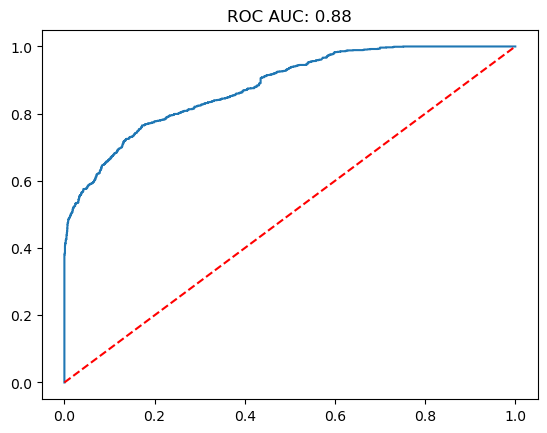

Do you want to save the result? Y/N y


In [76]:
model_validation(XGBClassifier(**best_xgb),x_train,y_train,x_test,y_test)

In [77]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251
6,AdaBoostClassifier(n_estimators=120),0.732626,0.570431,0.816667,0.671693,0.457909
7,GradientBoostingClassifier(n_estimators=50),0.843985,0.785905,0.734167,0.759156,0.643976
8,"XGBClassifier(base_score=None, booster=None, c...",0.787887,0.654062,0.778333,0.710807,0.545314


## Voting

In [78]:
from sklearn.ensemble import VotingClassifier,StackingClassifier

base_estimators=[('DT',DecisionTreeClassifier(**best_dt,class_weight=weights_dict)),('RF',RandomForestClassifier(**best_rf,class_weight=weights_dict)),
                 ('GBM',GradientBoostingClassifier(**best_gbm)),('XGB',XGBClassifier(**best_xgb))]

Confusion Matrix:
 [[2021  362]
 [ 290  910]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      2383
           1       0.72      0.76      0.74      1200

    accuracy                           0.82      3583
   macro avg       0.79      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



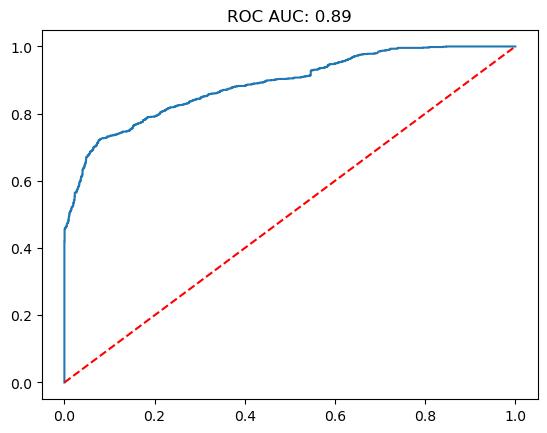

Do you want to save the result? Y/N y


In [79]:
model_validation(VotingClassifier(estimators=base_estimators,voting='soft',weights=(0.8,0.8,1.2,1.1)),x_train,y_train,x_test,y_test)

In [80]:
scorecard


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251
6,AdaBoostClassifier(n_estimators=120),0.732626,0.570431,0.816667,0.671693,0.457909
7,GradientBoostingClassifier(n_estimators=50),0.843985,0.785905,0.734167,0.759156,0.643976
8,"XGBClassifier(base_score=None, booster=None, c...",0.787887,0.654062,0.778333,0.710807,0.545314
9,"VotingClassifier(estimators=[('DT',\n ...",0.818030,0.715409,0.758333,0.736246,0.597525


Confusion Matrix:
 [[2154  229]
 [ 438  762]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      2383
           1       0.77      0.64      0.70      1200

    accuracy                           0.81      3583
   macro avg       0.80      0.77      0.78      3583
weighted avg       0.81      0.81      0.81      3583



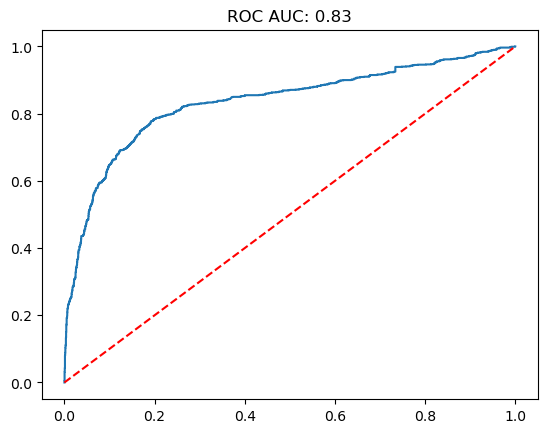

Do you want to save the result? Y/N y


In [81]:
model_validation(StackingClassifier(estimators=base_estimators),x_train,y_train,x_test,y_test)

In [82]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251
6,AdaBoostClassifier(n_estimators=120),0.732626,0.570431,0.816667,0.671693,0.457909
7,GradientBoostingClassifier(n_estimators=50),0.843985,0.785905,0.734167,0.759156,0.643976
8,"XGBClassifier(base_score=None, booster=None, c...",0.787887,0.654062,0.778333,0.710807,0.545314
9,"VotingClassifier(estimators=[('DT',\n ...",0.818030,0.715409,0.758333,0.736246,0.597525


In [83]:
#model_validation(StackingClassifier(estimators=base_estimators),final_estimators=DecisonTreeClassifier(max_depth=3,class_weight=weights_dict),
             #    x_train,y_train,x_test,y_test)

## Final Model

In [84]:
best_xgb

{'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 70}

In [85]:
grid={'max_depth':[3,4,5,6,7],'learning_rate':[0.5,0.2,0.1,1],'n_estimators':[65,70,67,72,75,80,85,100]}

In [86]:
final_xgb=tuning_parameters(grid=grid,estimator=XGBClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


In [87]:
final_xgb

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 65}

Confusion Matrix:
 [[1836  547]
 [ 246  954]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      2383
           1       0.64      0.80      0.71      1200

    accuracy                           0.78      3583
   macro avg       0.76      0.78      0.76      3583
weighted avg       0.80      0.78      0.78      3583



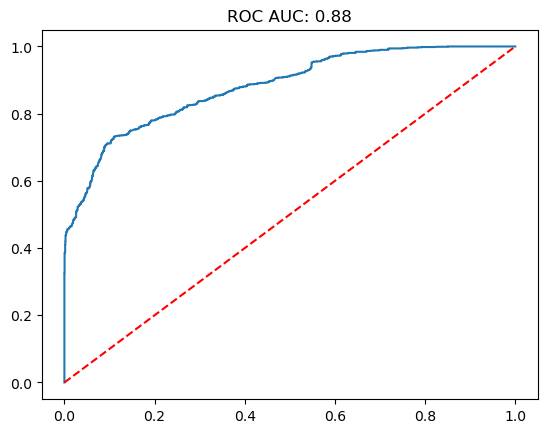

Do you want to save the result? Y/N y


In [88]:
model_validation(XGBClassifier(**final_xgb),x_train,y_train,x_test,y_test)

In [89]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(class_weight={0: 0.70290128...,0.740441,0.586985,0.759167,0.662064,0.456910
1,GaussianNB(),0.734301,0.597331,0.634167,0.615198,0.412577
2,LogisticRegression(),0.780073,0.738426,0.531667,0.618217,0.469456
3,MultinomialNB(),0.642199,0.477423,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.765839,0.612742,0.817500,0.700464,0.514637
5,RandomForestClassifier(class_weight={0: 0.7029...,0.750768,0.592414,0.820000,0.687871,0.489251
6,AdaBoostClassifier(n_estimators=120),0.732626,0.570431,0.816667,0.671693,0.457909
7,GradientBoostingClassifier(n_estimators=50),0.843985,0.785905,0.734167,0.759156,0.643976
8,"XGBClassifier(base_score=None, booster=None, c...",0.787887,0.654062,0.778333,0.710807,0.545314
9,"VotingClassifier(estimators=[('DT',\n ...",0.818030,0.715409,0.758333,0.736246,0.597525


In [97]:
from sklearn.ensemble import GradientBoostingClassifier

# Assuming final_model is a GradientBoostingClassifier or similar
final_model = XGBClassifier(**best_xgb)

# Fit the model
final_model.fit(x_train, y_train)

# Now you can safely access the feature_importances_ attribute
fi = final_model.feature_importances_

print(fi)


[0.18842612 0.24345912 0.17260122 0.09089589 0.02654064 0.04720914
 0.08760048 0.03844455 0.02077247 0.06405267 0.01999761]


In [98]:
final_model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [99]:
final_model.score

<bound method ClassifierMixin.score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)>

## Buisness Interpretations

In [100]:
fi=final_model.feature_importances_

In [101]:
fi_data=pd.DataFrame({'Feature importances' :fi},index=x_train.columns).sort_values(by='Feature importances',ascending=False)

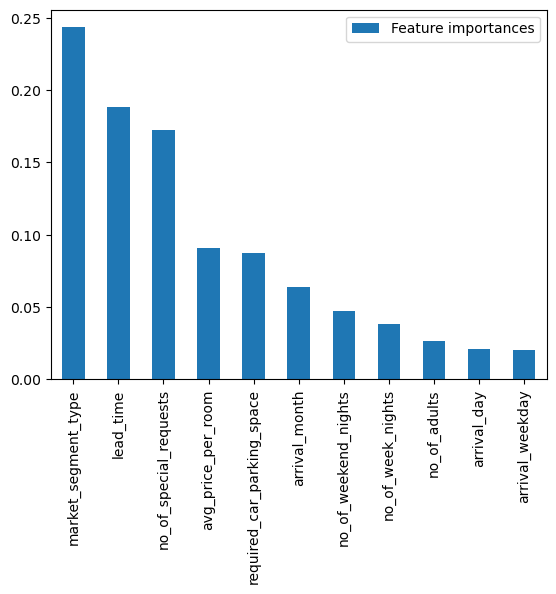

In [102]:
fi_data.plot(kind='bar')
plt.show()

## Deployment

In [103]:
# Saviing it into the pickle file
import pickle

with open('final_model_xgb.pkl','wb') as file:
    pickle.dump(final_model,file)